# Congressional Record and Hansard Word Embeddings Analysis


This notebook cotains the code to create a variety of different word embeddings from the Congressional Record and Hansard. Word embeddings are used to investigate the following hypotheses:

- Hypothesis 1 a): Labour and Conservative politicians use more similar language to discuss climate change than they do in general.
- Hypothesis 1 b): The langauge used by Labour and Conservative politicians to discuss climate change has become more similar over time.
- Hypothesis 2: Democrat and Republican politicians use less similar langauage to discuss climate change than they do in general.
- Hypothesis 4: Democrat and Republican politicians use less similar language to discuss climate change than Labour and Conservative politicians.

Word embeddings are generated using the pre-trained `all-MiniLM-L6-v2` model from sentence-transformers.


## Setup


In [1]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

DATA_PATH = 'data/'
DIST_PATH = 'dist/'

EMBEDDINGS_PATH = '../../glove-embeddings/'

plt.style.use('ggplot')

/Users/felixwallis/Desktop/UCL Politics and International Relations Course/Dissertation.nosync/pir-dissertation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generating word embeddings


### Functions for GloVe embeddings


In [2]:
word_vectors = KeyedVectors.load_word2vec_format(
    f'{EMBEDDINGS_PATH}glove.840B.300d.txt', binary=False, no_header=True)

In [3]:
def get_weighted_embedding(doc, tokens_column, word_vectors, tfidf_matrix, feature_names):
    doc_tokens = doc[tokens_column].split()
    doc_embedding = np.zeros(word_vectors.vector_size)

    # Get the document index in the TF-IDF matrix
    doc_index = doc.name

    # Get the column indices and values for the current document in the TF-IDF matrix
    col_indices = tfidf_matrix[doc_index].indices
    tfidf_scores = tfidf_matrix[doc_index].data

    # Create a dictionary of token to TF-IDF score for the current document
    tfidf_dict = {feature_names[col_index]: score for col_index, score in zip(
        col_indices, tfidf_scores)}

    # Calculate the weighted embedding by summing the product of word vectors and TF-IDF scores
    weighted_vectors = [word_vectors[token] * tfidf_dict.get(
        token, 0) for token in doc_tokens if token in word_vectors.key_to_index]
    if weighted_vectors:
        doc_embedding = sum(weighted_vectors)

    # Normalize by dividing by the number of words in the sentence
    if len(doc_tokens) > 0:
        doc_embedding /= len(doc_tokens)

    return doc_embedding


def generate_weighted_embeddings(corpus_df, tokens_column, word_vectors):
    # Create a TF-IDF vectorizer and calculate the TF-IDF matrix
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_df[tokens_column])

    # Convert the TF-IDF matrix to a compressed sparse row matrix for efficient row-wise access
    tfidf_matrix_csr = csr_matrix(tfidf_matrix)

    # Get the feature names (tokens) from the vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    tqdm.pandas(desc="Generating weighted embeddings")
    corpus_df['weighted_embedding'] = corpus_df.progress_apply(
        lambda doc: get_weighted_embedding(
            doc, tokens_column, word_vectors, tfidf_matrix_csr, feature_names),
        axis=1
    )

    return corpus_df

### Embedding the Congressional Record and Hansard


**Embedding the Congressional Record**


In [4]:
congressional_record = pd.read_csv(
    DATA_PATH + 'non_procedural_congressional_record.csv')

congressional_record_embeddings = generate_weighted_embeddings(
    congressional_record, 'cleaned_tokens', word_vectors)

congressional_record_embeddings.to_parquet(
    DATA_PATH + 'congressional_record_embeddings.parquet')

del congressional_record
del congressional_record_embeddings

Generating weighted embeddings: 100%|██████████| 480633/480633 [03:01<00:00, 2645.11it/s]


**Embedding Hansard**


In [5]:
hansard = pd.read_csv(DATA_PATH + 'non_procedural_hansard.csv')

hansard_embeddings = generate_weighted_embeddings(
    hansard, 'cleaned_tokens', word_vectors)

hansard_embeddings.to_parquet(DATA_PATH + 'hansard_embeddings.parquet')

del hansard
del hansard_embeddings

Generating weighted embeddings: 100%|██████████| 523556/523556 [01:12<00:00, 7242.73it/s] 


### Embedding the Climate Congressional Record and Climate Hansard datasets


**Embedding the Congressional Record**


In [6]:
climate_congressional_record = pd.read_csv(
    DATA_PATH + 'climate_congressional_record.csv')

climate_congressional_record_embeddings = generate_weighted_embeddings(
    climate_congressional_record, 'cleaned_tokens', word_vectors)

climate_congressional_record_embeddings.to_parquet(
    DATA_PATH + 'climate_congressional_record_embeddings.parquet')

del climate_congressional_record
del climate_congressional_record_embeddings

Generating weighted embeddings: 100%|██████████| 27339/27339 [00:07<00:00, 3846.20it/s]


**Embedding Hansard**


In [7]:
climate_hansard = pd.read_csv(DATA_PATH + 'climate_hansard.csv')

climate_hansard_embeddings = generate_weighted_embeddings(
    climate_hansard, 'cleaned_tokens', word_vectors)

climate_hansard_embeddings.to_parquet(
    DATA_PATH + 'climate_hansard_embeddings.parquet')

del climate_hansard
del climate_hansard_embeddings

Generating weighted embeddings: 100%|██████████| 30082/30082 [00:03<00:00, 9409.72it/s] 


## UMAP Visualisation


These visualisations are primarily exploratory. However, they also give some insight into Hypotheses 1a) and 2 by comparing the similarity of language used by Labour and Conservative politicians and Democrat and Republican politicians respectively.


### Transforming the embeddings to 3D with UMAP


In [8]:
umap_model = umap.UMAP(n_neighbors=15, n_components=3, metric='cosine')

files = [
    (DATA_PATH + 'congressional_record_embeddings.parquet', DATA_PATH +
     'congressional_record_embeddings.parquet'),
    (DATA_PATH + 'hansard_embeddings.parquet', DATA_PATH +
        'hansard_embeddings.parquet'),
    (DATA_PATH + 'climate_congressional_record_embeddings.parquet', DATA_PATH +
     'climate_congressional_record_embeddings.parquet'),
    (DATA_PATH + 'climate_hansard_embeddings.parquet', DATA_PATH +
     'climate_hansard_embeddings.parquet')
]

for file_path, output_file_path in tqdm(files, desc="Processing files"):
    embeddings = pd.read_parquet(file_path)

    umap_embeddings = umap_model.fit_transform(
        embeddings['weighted_embedding'].tolist())

    embeddings['reduced_dim_embedding'] = umap_embeddings.tolist()

    embeddings.to_parquet(output_file_path, index=False)

    del embeddings
    del umap_embeddings

Processing files: 100%|██████████| 4/4 [09:17<00:00, 139.29s/it]


### Visualising the Congressional Record and Hansard embeddings


In [9]:
congressional_record_embeddings = pd.read_parquet(
    DATA_PATH + 'congressional_record_embeddings.parquet')
hansard_embeddings = pd.read_parquet(
    DATA_PATH + 'hansard_embeddings.parquet')

umap_congressional_record_embeddings = np.array(
    congressional_record_embeddings['reduced_dim_embedding'].tolist())
umap_hansard_embeddings = np.array(
    hansard_embeddings['reduced_dim_embedding'].tolist())

**Congressional Record versus Hansard**


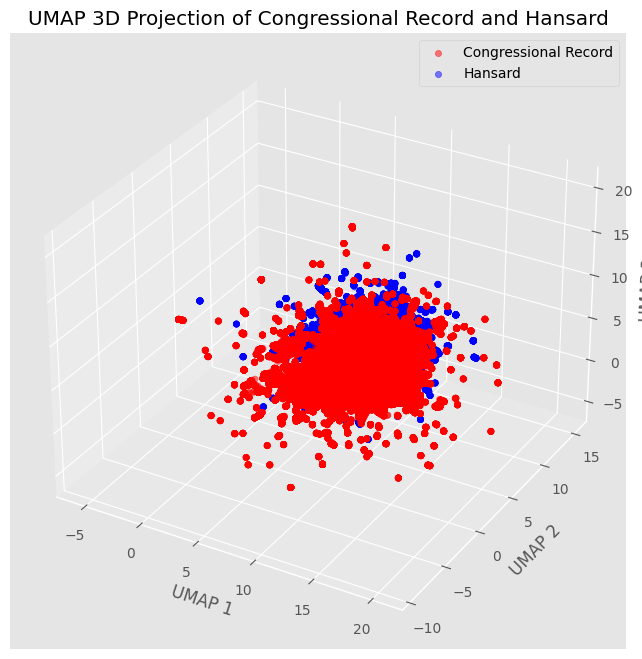

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(umap_congressional_record_embeddings[:, 0],
           umap_congressional_record_embeddings[:, 1],
           umap_congressional_record_embeddings[:, 2],
           alpha=0.5, c='red', label='Congressional Record')
ax.scatter(umap_hansard_embeddings[:, 0],
           umap_hansard_embeddings[:, 1],
           umap_hansard_embeddings[:, 2],
           alpha=0.5, c='blue', label='Hansard')

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP 3D Projection of Congressional Record and Hansard')

ax.legend()

plt.show()

**Democrat versus Republican**


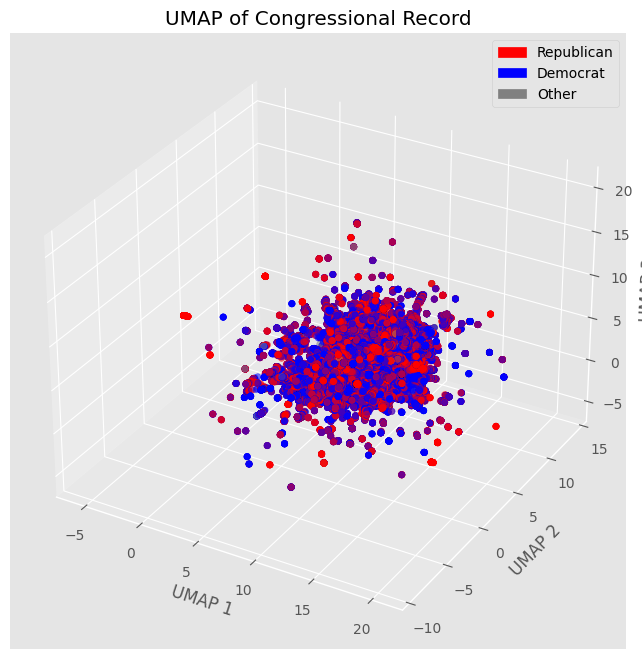

In [11]:
party_colours = {
    'R': 'red',
    'D': 'blue',
}
default_colour = 'grey'
colours = congressional_record_embeddings['party'].apply(
    lambda x: party_colours.get(x, default_colour))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(umap_congressional_record_embeddings[:, 0],
           umap_congressional_record_embeddings[:, 1],
           umap_congressional_record_embeddings[:, 2], alpha=0.5, c=colours)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP of Congressional Record')

legend_patches = [
    mpatches.Patch(color='red', label='Republican'),
    mpatches.Patch(color='blue', label='Democrat'),
    mpatches.Patch(color='grey', label='Other')
]
ax.legend(handles=legend_patches)

plt.show()

**Labour versus Conservative**


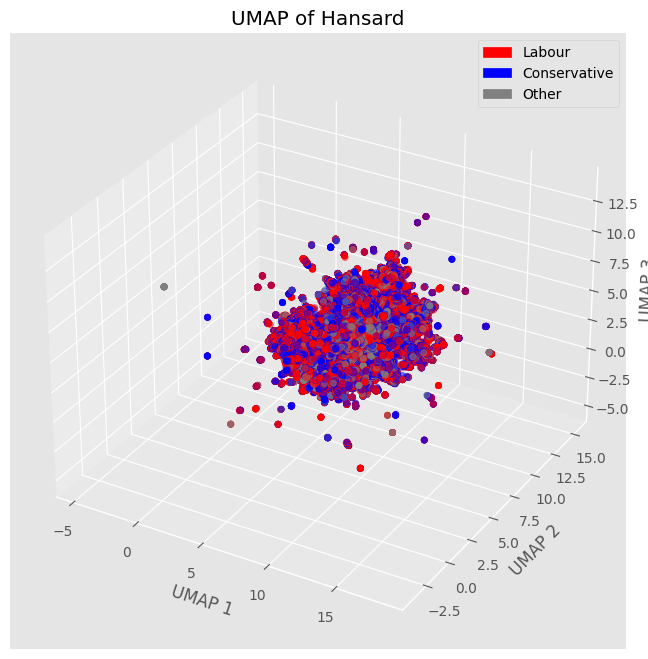

In [12]:
party_colours = {
    'Conservative': 'blue',
    'Labour': 'red',
}
default_colour = 'grey'
colours = hansard_embeddings['speech_party'].apply(
    lambda x: party_colours.get(x, default_colour))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(umap_hansard_embeddings[:, 0],
           umap_hansard_embeddings[:, 1],
           umap_hansard_embeddings[:, 2], alpha=0.5, c=colours)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP of Hansard')

legend_patches = [
    mpatches.Patch(color='red', label='Labour'),
    mpatches.Patch(color='blue', label='Conservative'),
    mpatches.Patch(color='grey', label='Other')
]
ax.legend(handles=legend_patches)

plt.show()

**Democrat versus Labour**


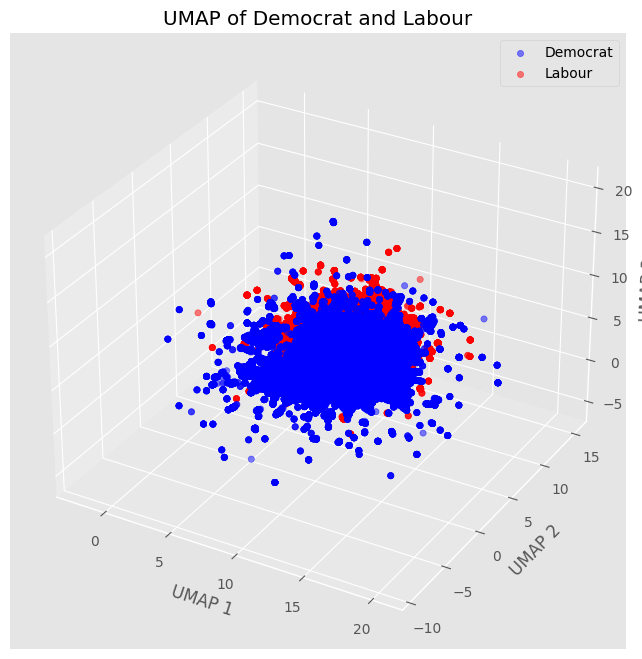

In [13]:
democrat_mask = (congressional_record_embeddings['party'] == 'D')
labour_mask = (hansard_embeddings['speech_party'] == 'Labour')

umap_democrat_embeddings = umap_congressional_record_embeddings[democrat_mask]
umap_labour_embeddings = umap_hansard_embeddings[labour_mask]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(umap_democrat_embeddings[:, 0],
           umap_democrat_embeddings[:, 1],
           umap_democrat_embeddings[:, 2], alpha=0.5, c='blue', label='Democrat')

ax.scatter(umap_labour_embeddings[:, 0],
           umap_labour_embeddings[:, 1],
           umap_labour_embeddings[:, 2], alpha=0.5, c='red', label='Labour')

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP of Democrat and Labour')

ax.legend()

plt.show()

**Republican versus Conservative**


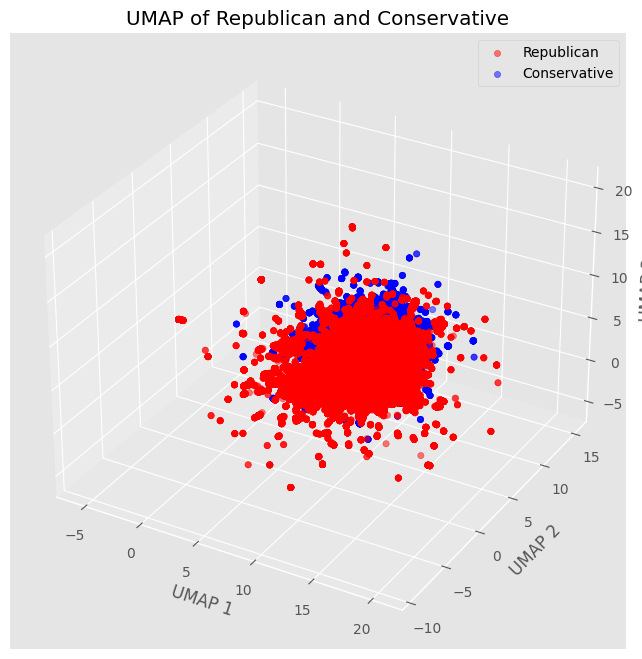

In [14]:
republican_mask = (congressional_record_embeddings['party'] == 'R')
conservative_mask = (hansard_embeddings['speech_party'] == 'Conservative')

umap_republican_embeddings = umap_congressional_record_embeddings[republican_mask]
umap_conservative_embeddings = umap_hansard_embeddings[conservative_mask]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(umap_republican_embeddings[:, 0],
           umap_republican_embeddings[:, 1],
           umap_republican_embeddings[:, 2], alpha=0.5, c='red', label='Republican')

ax.scatter(umap_conservative_embeddings[:, 0],
           umap_conservative_embeddings[:, 1],
           umap_conservative_embeddings[:, 2], alpha=0.5, c='blue', label='Conservative')

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP of Republican and Conservative')

ax.legend()

plt.show()

### Visualising the Climate Congressional Record and Climate Hansard embeddings


In [15]:
climate_congressional_record_embeddings = pd.read_parquet(
    DATA_PATH + 'climate_congressional_record_embeddings.parquet')
climate_hansard_embeddings = pd.read_parquet(
    DATA_PATH + 'climate_hansard_embeddings.parquet')

umap_climate_congressional_record_embeddings = np.array(
    climate_congressional_record_embeddings['reduced_dim_embedding'].tolist())
umap_climate_hansard_embeddings = np.array(
    climate_hansard_embeddings['reduced_dim_embedding'].tolist())

**Congressional Record versus Hansard**


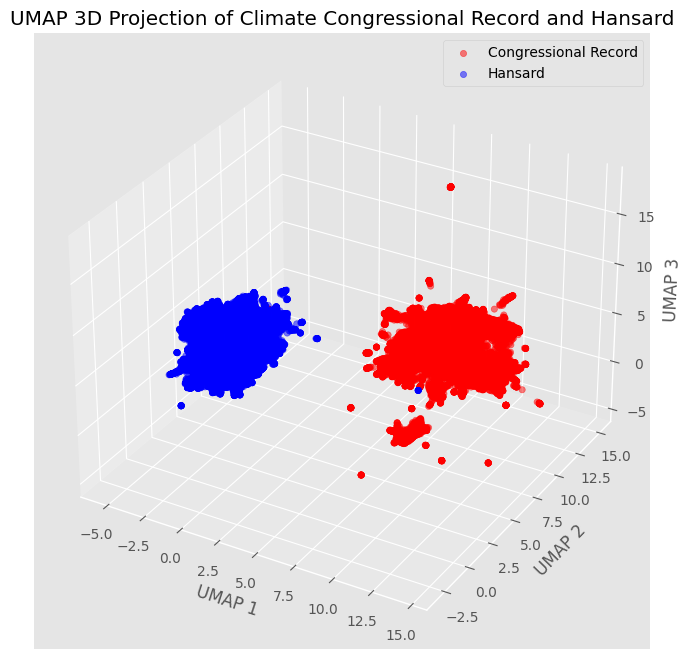

In [16]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(umap_climate_congressional_record_embeddings[:, 0],
           umap_climate_congressional_record_embeddings[:, 1],
           umap_climate_congressional_record_embeddings[:, 2],
           alpha=0.5, c='red', label='Congressional Record')

ax.scatter(umap_climate_hansard_embeddings[:, 0],
           umap_climate_hansard_embeddings[:, 1],
           umap_climate_hansard_embeddings[:, 2],
           alpha=0.5, c='blue', label='Hansard')

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP 3D Projection of Climate Congressional Record and Hansard')
ax.legend()
plt.show()

**Democrat versus Republican**


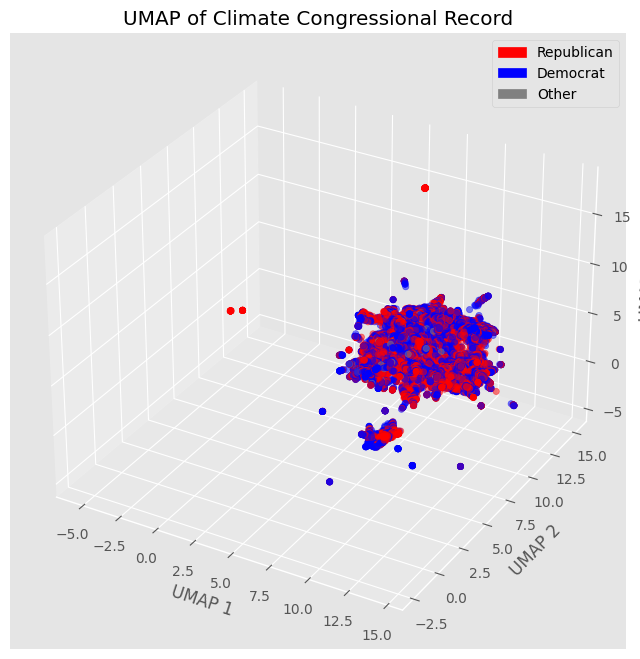

In [17]:
party_colours = {
    'R': 'red',
    'D': 'blue',
}
default_colour = 'grey'
colours = climate_congressional_record_embeddings['party'].apply(
    lambda x: party_colours.get(x, default_colour))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(umap_climate_congressional_record_embeddings[:, 0],
           umap_climate_congressional_record_embeddings[:, 1],
           umap_climate_congressional_record_embeddings[:, 2], alpha=0.5, c=colours)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP of Climate Congressional Record')

legend_patches = [
    mpatches.Patch(color='red', label='Republican'),
    mpatches.Patch(color='blue', label='Democrat'),
    mpatches.Patch(color='grey', label='Other')
]
ax.legend(handles=legend_patches)

plt.show()

**Labour versus Conservative**


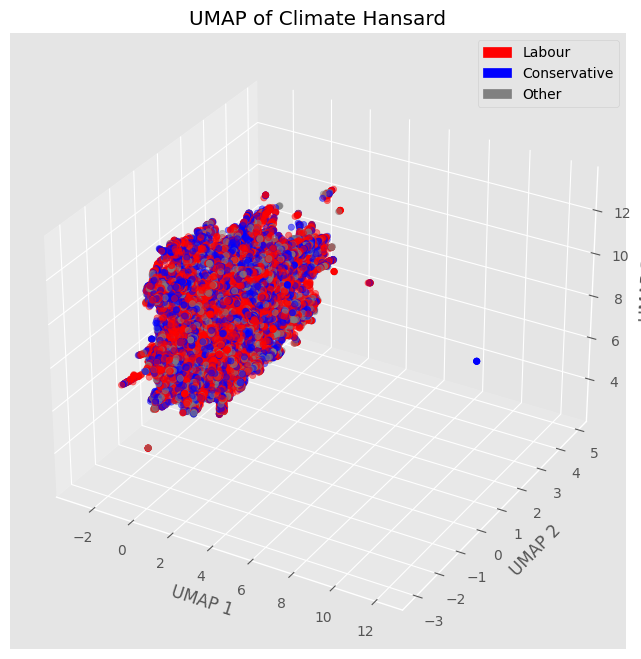

In [18]:
party_colours = {
    'Conservative': 'blue',
    'Labour': 'red',
}
default_colour = 'grey'
colours = climate_hansard_embeddings['speech_party'].apply(
    lambda x: party_colours.get(x, default_colour))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(umap_climate_hansard_embeddings[:, 0],
           umap_climate_hansard_embeddings[:, 1],
           umap_climate_hansard_embeddings[:, 2], alpha=0.5, c=colours)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP of Climate Hansard')

legend_patches = [
    mpatches.Patch(color='red', label='Labour'),
    mpatches.Patch(color='blue', label='Conservative'),
    mpatches.Patch(color='grey', label='Other')
]
ax.legend(handles=legend_patches)

plt.show()

**Democrat versus Labour**


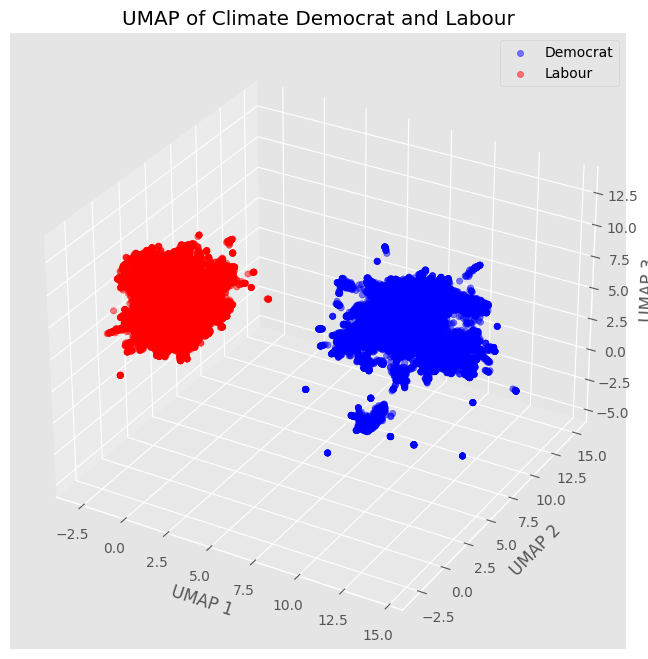

In [19]:
climate_democrat_mask = (
    climate_congressional_record_embeddings['party'] == 'D')
climate_labour_mask = (climate_hansard_embeddings['speech_party'] == 'Labour')

umap_climate_democrat_embeddings = umap_climate_congressional_record_embeddings[
    climate_democrat_mask]
umap_climate_labour_embeddings = umap_climate_hansard_embeddings[climate_labour_mask]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(umap_climate_democrat_embeddings[:, 0],
           umap_climate_democrat_embeddings[:, 1],
           umap_climate_democrat_embeddings[:, 2], alpha=0.5, c='blue', label='Democrat')

ax.scatter(umap_climate_labour_embeddings[:, 0],
           umap_climate_labour_embeddings[:, 1],
           umap_climate_labour_embeddings[:, 2], alpha=0.5, c='red', label='Labour')

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP of Climate Democrat and Labour')

ax.legend()

plt.show()

**Republican versus Conservative**


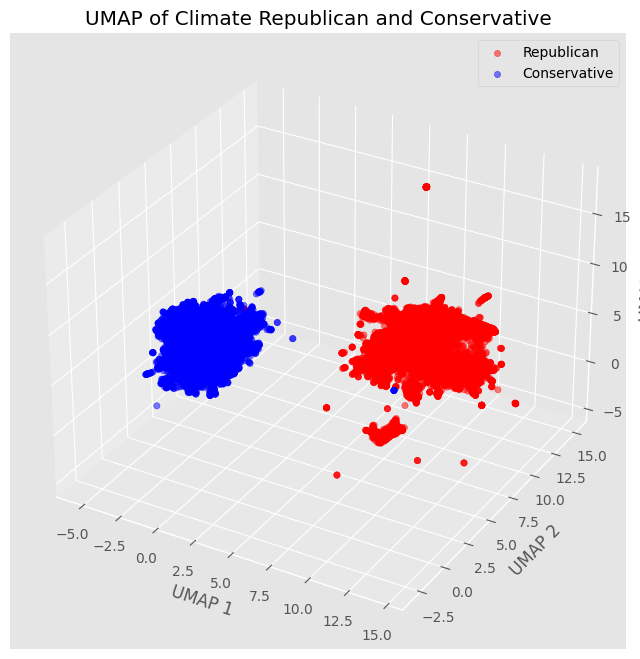

In [20]:
climate_republican_mask = (
    climate_congressional_record_embeddings['party'] == 'R')
climate_conservative_mask = (
    climate_hansard_embeddings['speech_party'] == 'Conservative')

umap_climate_republican_embeddings = umap_climate_congressional_record_embeddings[
    climate_republican_mask]
umap_climate_conservative_embeddings = umap_climate_hansard_embeddings[
    climate_conservative_mask]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(umap_climate_republican_embeddings[:, 0],
           umap_climate_republican_embeddings[:, 1],
           umap_climate_republican_embeddings[:, 2], alpha=0.5, c='red', label='Republican')

ax.scatter(umap_climate_conservative_embeddings[:, 0],
           umap_climate_conservative_embeddings[:, 1],
           umap_climate_conservative_embeddings[:, 2], alpha=0.5, c='blue', label='Conservative')

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP of Climate Republican and Conservative')

ax.legend()

plt.show()

## Time series analysis


In [21]:
congressional_record_embeddings = pd.read_parquet(
    DATA_PATH + 'congressional_record_embeddings.parquet')
hansard_embeddings = pd.read_parquet(DATA_PATH + 'hansard_embeddings.parquet')

climate_congressional_record_embeddings = pd.read_parquet(
    DATA_PATH + 'climate_congressional_record_embeddings.parquet')
climate_hansard_embeddings = pd.read_parquet(
    DATA_PATH + 'climate_hansard_embeddings.parquet')

### Calculating the centroids of the Congressional Record and Hansard embeddings over time


In [22]:
congressional_record_embeddings['year_month'] = pd.to_datetime(
    congressional_record_embeddings['date']).dt.to_period('M')
hansard_embeddings['year_month'] = pd.to_datetime(
    hansard_embeddings['speech_date']).dt.to_period('M')

climate_congressional_record_embeddings['year_month'] = pd.to_datetime(
    climate_congressional_record_embeddings['date']).dt.to_period('M')
climate_hansard_embeddings['year_month'] = pd.to_datetime(
    climate_hansard_embeddings['speech_date']).dt.to_period('M')


def calculate_period_centroids(embeddings_df):
    data = []
    for year_month in embeddings_df['year_month'].unique():
        year_month_embeddings = embeddings_df[embeddings_df['year_month'] == year_month]

        centroid = year_month_embeddings['weighted_embedding'].mean(axis=0)
        data.append([year_month, centroid])

    centroids_df = pd.DataFrame(
        data, columns=['year_month', 'centroid'])
    return centroids_df

**Congressional Record and Hansard Centroids**


In [23]:
congressional_record_centroids = calculate_period_centroids(
    congressional_record_embeddings)

hansard_centroids = calculate_period_centroids(hansard_embeddings)

**Democrat and Republican centroids**


In [24]:
democrat_embeddings = congressional_record_embeddings[
    congressional_record_embeddings['party'] == 'D']
democrat_centroids = calculate_period_centroids(democrat_embeddings)

republican_embeddings = congressional_record_embeddings[
    congressional_record_embeddings['party'] == 'R']
republican_centroids = calculate_period_centroids(
    congressional_record_embeddings)

**Labour and Conservative centroids**


In [25]:
labour_embeddings = hansard_embeddings[hansard_embeddings['speech_party'] == 'Labour']
labour_centroids = calculate_period_centroids(labour_embeddings)

conservative_embeddings = hansard_embeddings[hansard_embeddings['speech_party'] == 'Conservative']
conservative_centroids = calculate_period_centroids(conservative_embeddings)

### Calculating the centroids of the Climate Congressional Record and Climate Hansard embeddings over time


**Congressional Record and Hansard Centroids**


In [26]:
climate_congressional_record_centroids = calculate_period_centroids(
    climate_congressional_record_embeddings)

climate_hansard_centroids = calculate_period_centroids(
    climate_hansard_embeddings)

**Democrat and Republican centroids**


In [27]:
climate_democrat_embeddings = climate_congressional_record_embeddings[
    climate_congressional_record_embeddings['party'] == 'D']
climate_democrat_centroids = calculate_period_centroids(
    climate_democrat_embeddings)

climate_republican_embeddings = climate_congressional_record_embeddings[
    climate_congressional_record_embeddings['party'] == 'R']
climate_republican_centroids = calculate_period_centroids(
    climate_republican_embeddings)

**Labour and Conservative centroids**


In [28]:
climate_labour_embeddings = climate_hansard_embeddings[
    climate_hansard_embeddings['speech_party'] == 'Labour']
climate_labour_centroids = calculate_period_centroids(
    climate_labour_embeddings)

climate_conservative_embeddings = climate_hansard_embeddings[
    climate_hansard_embeddings['speech_party'] == 'Conservative']
climate_conservative_centroids = calculate_period_centroids(
    climate_conservative_embeddings)

### Creating a dataframe of centroid cosine similarity over time


**Functions to create the cosine similarity dataframe**


In [29]:
def calculate_cosine_similarities_over_time(centroids_1: pd.DataFrame, centroids_2: pd.DataFrame):
    common_periods = centroids_1['year_month'].isin(centroids_2['year_month'])
    centroids_1 = centroids_1[common_periods]

    similarities = []
    for year_month, centroid_1 in centroids_1[['year_month', 'centroid']].values:
        centroid_2 = centroids_2.loc[centroids_2['year_month']
                                     == year_month, 'centroid'].values[0]
        centroid_similarity = cosine_similarity(
            [centroid_1], [centroid_2])[0, 0]
        similarities.append(
            {'year_month': year_month, 'centroid_similarity': centroid_similarity})

    return pd.DataFrame(similarities)


def create_cosine_similarity_df(main_df: pd.DataFrame,
                                centroids_1: pd.DataFrame,
                                centroids_2: pd.DataFrame,
                                column_prefix: str):
    similarities_df = calculate_cosine_similarities_over_time(
        centroids_1, centroids_2)
    similarities_df = similarities_df.rename(
        columns={'centroid_similarity': f'{column_prefix}_centroid_similarity'})
    return main_df.join(similarities_df.set_index('year_month'), how='left')

**Creating the cosine similarity dataframe**


In [30]:
all_dates = pd.date_range(
    start=congressional_record_embeddings['year_month'].min().to_timestamp(),
    end=congressional_record_embeddings['year_month'].max().to_timestamp(),
    freq='M'
)
all_dates = all_dates.to_period('M')
cosine_similarities_df = pd.DataFrame(index=all_dates)


# Congressional Record and Hansard cosine similarities
cosine_similarities_df = create_cosine_similarity_df(
    cosine_similarities_df, congressional_record_centroids, hansard_centroids, 'congressional_record_hansard')

# Democrat and Republican cosine similarities
cosine_similarities_df = create_cosine_similarity_df(
    cosine_similarities_df, democrat_centroids, republican_centroids, 'democrat_republican')

# Labour and Conservative cosine similarities
cosine_similarities_df = create_cosine_similarity_df(
    cosine_similarities_df, labour_centroids, conservative_centroids, 'labour_conservative')

# Climate Congressional Record and Hansard cosine similarities
cosine_similarities_df = create_cosine_similarity_df(
    cosine_similarities_df, climate_congressional_record_centroids, climate_hansard_centroids, 'climate_congressional_record_hansard')

# Climate Democrat and Republican cosine similarities
cosine_similarities_df = create_cosine_similarity_df(
    cosine_similarities_df, climate_democrat_centroids, climate_republican_centroids, 'climate_democrat_republican')

# Climate Labour and Conservative cosine similarities
cosine_similarities_df = create_cosine_similarity_df(
    cosine_similarities_df, climate_labour_centroids, climate_conservative_centroids, 'climate_labour_conservative')

cosine_similarities_df = cosine_similarities_df.ffill()
cosine_similarities_df = cosine_similarities_df.bfill()

### Plotting the centroid cosine similarities over time


In [31]:
timestamps = cosine_similarities_df.index.to_timestamp()

**Congressional Record and Hansard centroid cosine similarities**


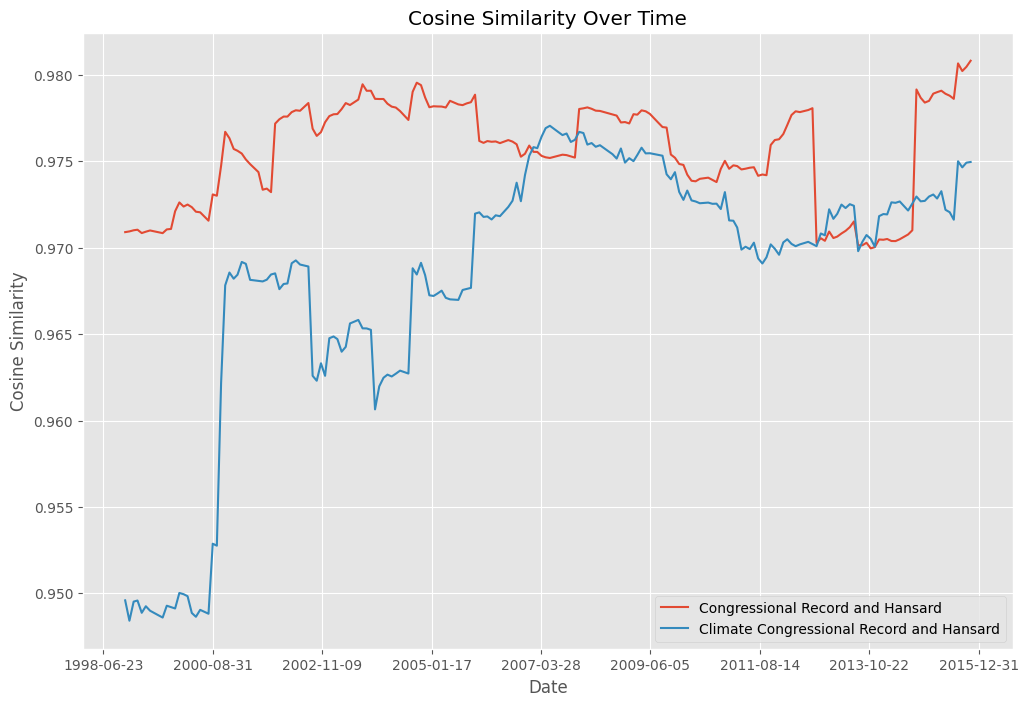

In [32]:
plt.figure(figsize=(12, 8))
ax = plt.gca()
plt.plot(timestamps, cosine_similarities_df['congressional_record_hansard_centroid_similarity'].rolling(
    window=24).mean(),
    label='Congressional Record and Hansard')
plt.plot(timestamps, cosine_similarities_df['climate_congressional_record_hansard_centroid_similarity'].rolling(
    window=24).mean(),
    label='Climate Congressional Record and Hansard')

plt.title('Cosine Similarity Over Time')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
# ax.set_xlim(pd.to_datetime("2000-01-01"), pd.to_datetime("2015-01-01"))
plt.xlabel('Date')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.show()

**Democrat and Republican centroid cosine similarities**


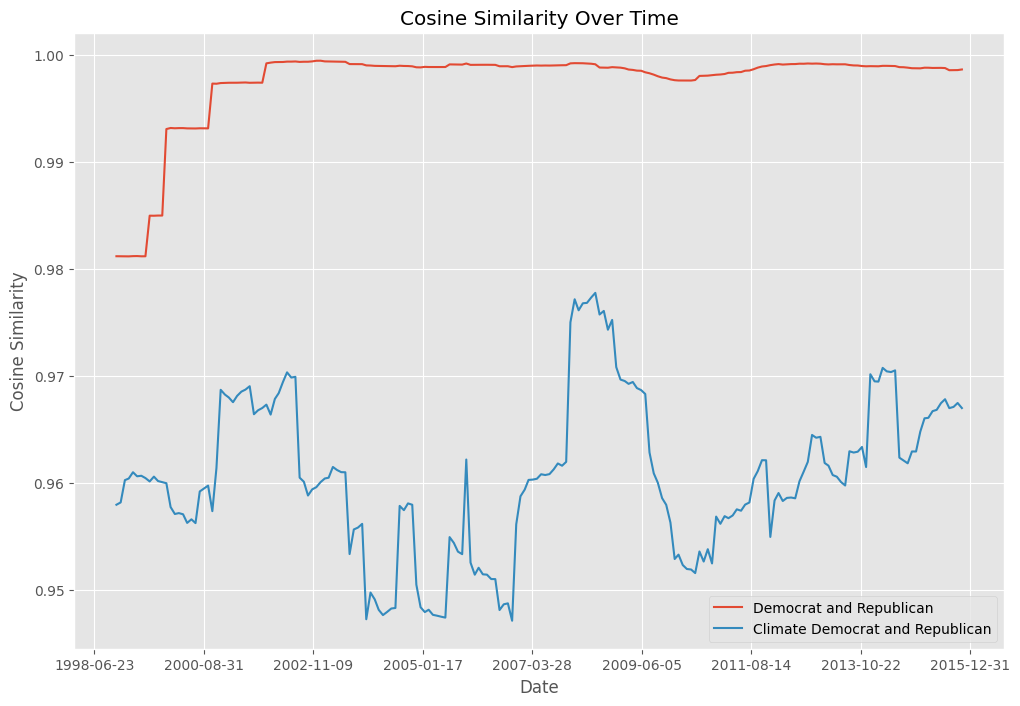

In [33]:
plt.figure(figsize=(12, 8))
ax = plt.gca()
plt.plot(timestamps, cosine_similarities_df['democrat_republican_centroid_similarity'].rolling(
    window=24).mean(),
    label='Democrat and Republican')
plt.plot(timestamps, cosine_similarities_df['climate_democrat_republican_centroid_similarity'].rolling(
    window=24).mean(),
    label='Climate Democrat and Republican')
plt.title('Cosine Similarity Over Time')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
# ax.set_xlim(pd.to_datetime("2000-01-01"), pd.to_datetime("2015-01-01"))
plt.xlabel('Date')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.show()

**Labour and Conservative centroid cosine similarities**


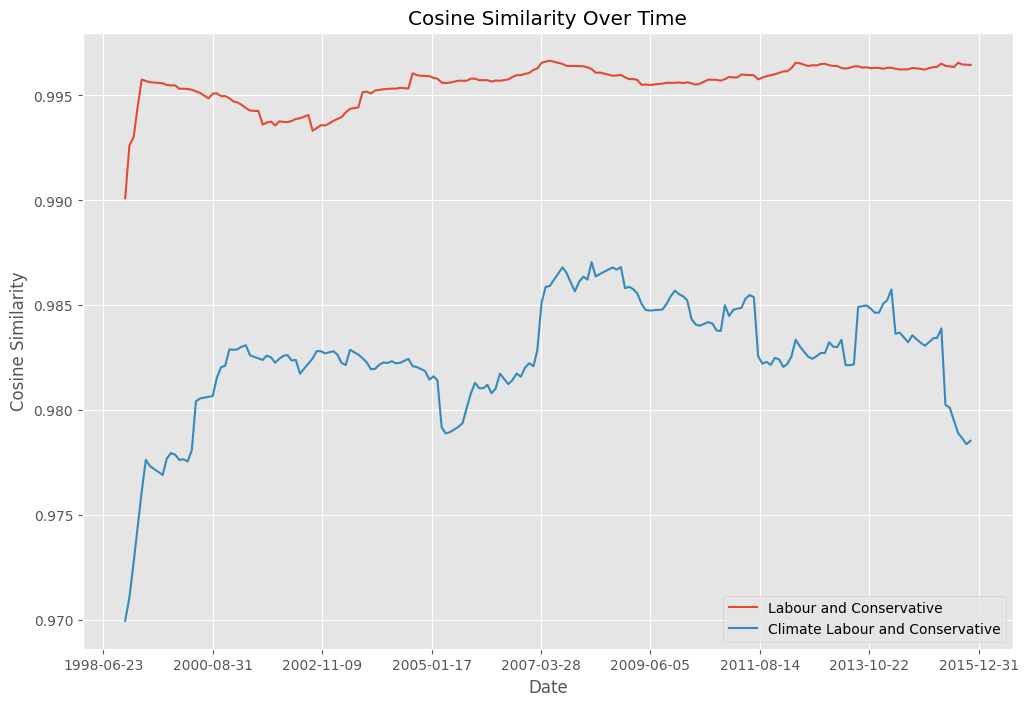

In [34]:
plt.figure(figsize=(12, 8))
ax = plt.gca()
plt.plot(timestamps, cosine_similarities_df['labour_conservative_centroid_similarity'].rolling(
    window=24).mean(),
    label='Labour and Conservative')
plt.plot(timestamps, cosine_similarities_df['climate_labour_conservative_centroid_similarity'].rolling(
    window=24).mean(),
    label='Climate Labour and Conservative')
plt.title('Cosine Similarity Over Time')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
# ax.set_xlim(pd.to_datetime("2000-01-01"), pd.to_datetime("2015-01-01"))
plt.xlabel('Date')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.show()

**Democrat and Republican and Labour and Conservative centroid cosine similarities**


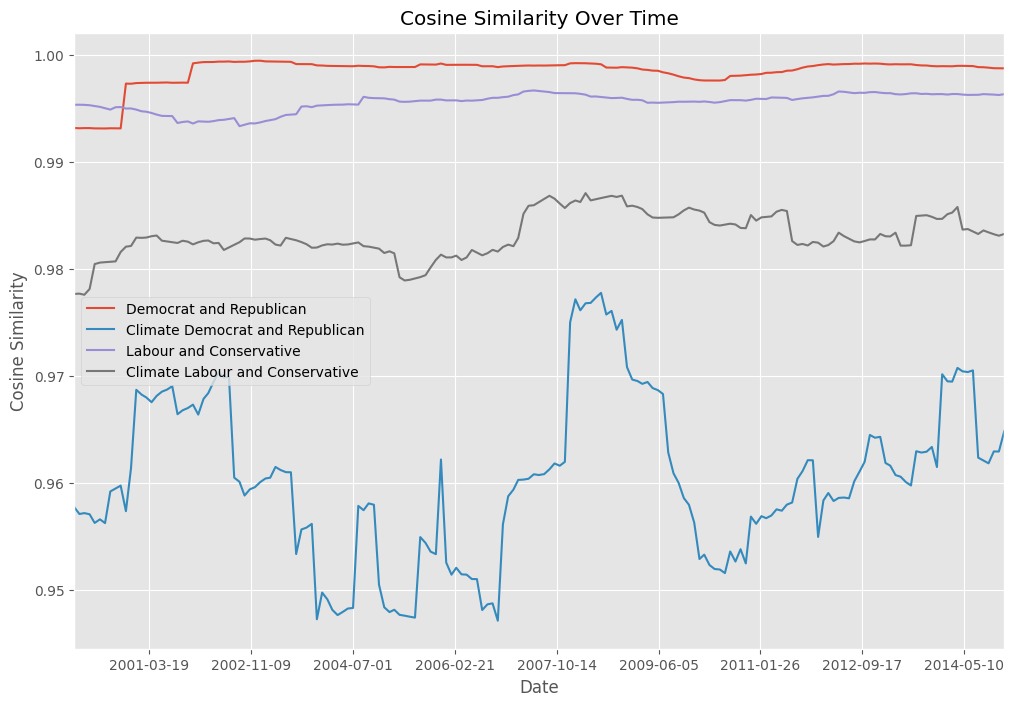

In [35]:
plt.figure(figsize=(12, 8))
ax = plt.gca()
plt.plot(timestamps, cosine_similarities_df['democrat_republican_centroid_similarity'].rolling(
    window=24).mean(),
    label='Democrat and Republican')
plt.plot(timestamps, cosine_similarities_df['climate_democrat_republican_centroid_similarity'].rolling(
    window=24).mean(),
    label='Climate Democrat and Republican')
plt.plot(timestamps, cosine_similarities_df['labour_conservative_centroid_similarity'].rolling(
    window=24).mean(),
    label='Labour and Conservative')
plt.plot(timestamps, cosine_similarities_df['climate_labour_conservative_centroid_similarity'].rolling(
    window=24).mean(),
    label='Climate Labour and Conservative')
plt.title('Cosine Similarity Over Time')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_xlim(pd.to_datetime("2000-01-01"), pd.to_datetime("2015-01-01"))
plt.xlabel('Date')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.show()

### Calculating the average cosine similarities of Climate Congressional Record and Climate Hansard embeddings over time


In [36]:
climate_hansard_embeddings['year_month'] = pd.to_datetime(
    climate_hansard_embeddings['speech_date']).dt.to_period('M')
climate_hansard_embeddings.sort_values('year_month', inplace=True)

climate_congressional_record_embeddings['year_month'] = pd.to_datetime(
    climate_congressional_record_embeddings['date']).dt.to_period('M')
climate_congressional_record_embeddings.sort_values('year_month', inplace=True)


def process_month(group):
    centroid = group['weighted_embedding'].mean(axis=0)
    group['cosine_distance_to_centroid'] = group['weighted_embedding'].apply(
        lambda x: 1 - cosine_similarity([x], [centroid])[0, 0])
    average_distance = group['cosine_distance_to_centroid'].mean()
    std_dev_distance = group['cosine_distance_to_centroid'].std()
    n = len(group)
    confidence_interval = 1.28 * \
        (std_dev_distance / np.sqrt(n))  # 90% confidence interval

    return pd.Series({
        'average_distance': average_distance,
        'std_dev_distance': std_dev_distance,
        'confidence_interval': confidence_interval,
        'upper_bound': average_distance + confidence_interval,
        'lower_bound': average_distance - confidence_interval,
        'num_docs': n
    })


climate_hansard_monthly_stats = climate_hansard_embeddings.groupby(
    'year_month').apply(process_month)
climate_hansard_monthly_stats = climate_hansard_monthly_stats[
    climate_hansard_monthly_stats['num_docs'] > 30]

climate_congressional_record_monthly_stats = climate_congressional_record_embeddings.groupby(
    'year_month').apply(process_month)
climate_congressional_record_monthly_stats = climate_congressional_record_monthly_stats[
    climate_congressional_record_monthly_stats['num_docs'] > 30]

all_dates = pd.date_range(
    start=climate_hansard_embeddings['year_month'].min().to_timestamp(),
    end=climate_hansard_embeddings['year_month'].max().to_timestamp(),
    freq='M'
)

all_dates = all_dates.to_period('M')
hansard_monthly_stats_df = pd.DataFrame(index=all_dates)
congress_monthly_stats_df = pd.DataFrame(index=all_dates)

hansard_monthly_stats_df = hansard_monthly_stats_df.join(
    climate_hansard_monthly_stats, how='left').interpolate(method='time')
congress_monthly_stats_df = congress_monthly_stats_df.join(
    climate_congressional_record_monthly_stats, how='left').interpolate(method='time')

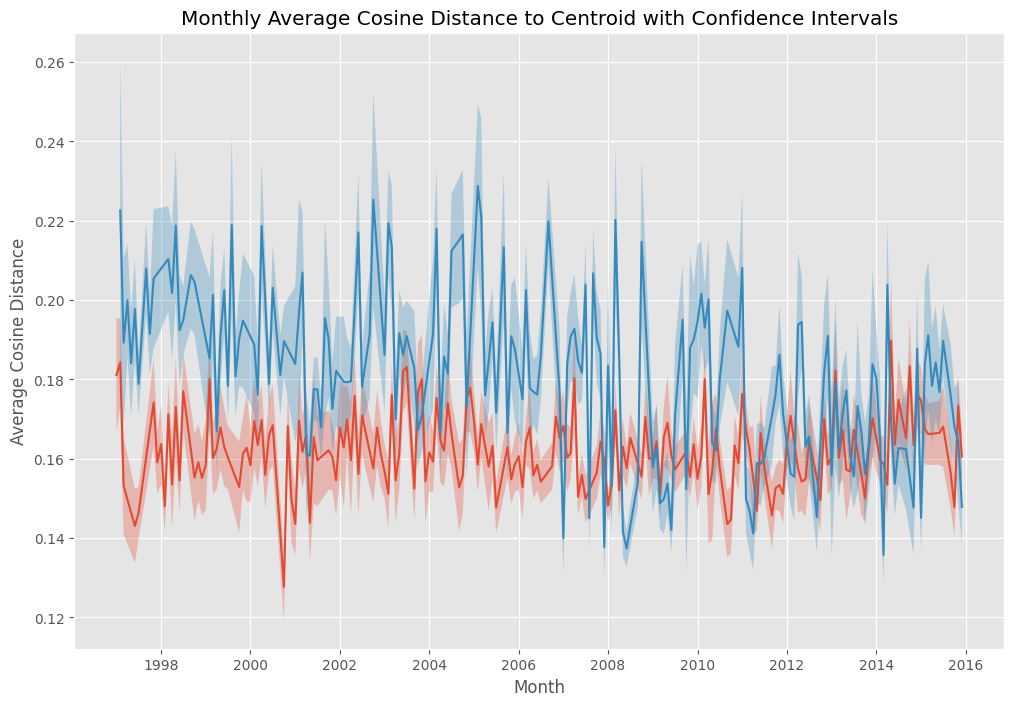

In [37]:
plt.figure(figsize=(12, 8))
plt.plot(climate_hansard_monthly_stats.index.to_timestamp(), climate_hansard_monthly_stats['average_distance']
         )
plt.plot(climate_congressional_record_monthly_stats.index.to_timestamp(), climate_congressional_record_monthly_stats['average_distance']
         )
plt.fill_between(climate_hansard_monthly_stats.index.to_timestamp(), climate_hansard_monthly_stats['lower_bound'],
                 climate_hansard_monthly_stats['upper_bound'], alpha=0.3)
plt.fill_between(climate_congressional_record_monthly_stats.index.to_timestamp(), climate_congressional_record_monthly_stats['lower_bound'],
                 climate_congressional_record_monthly_stats['upper_bound'], alpha=0.3)
plt.title('Monthly Average Cosine Distance to Centroid with Confidence Intervals')
plt.xlabel('Month')
plt.ylabel('Average Cosine Distance')
plt.grid(True)
plt.show()

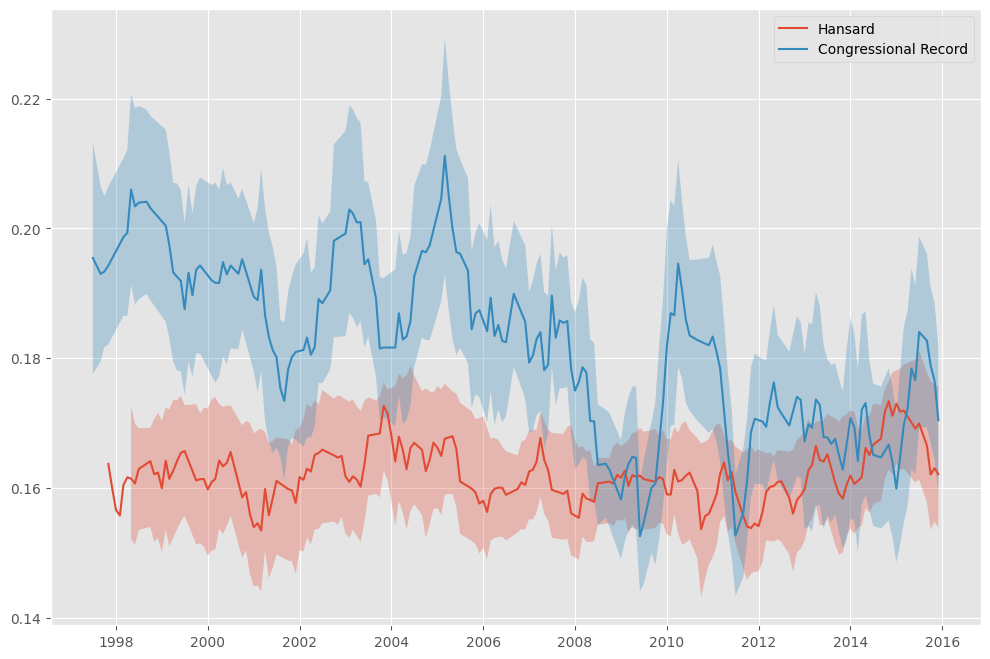

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(climate_hansard_monthly_stats.index.to_timestamp(), climate_hansard_monthly_stats['average_distance'].rolling(window=6).mean(), label='Hansard'
         )
plt.plot(climate_congressional_record_monthly_stats.index.to_timestamp(), climate_congressional_record_monthly_stats['average_distance'].rolling(window=6).mean(), label='Congressional Record'
         )
plt.fill_between(climate_hansard_monthly_stats.index.to_timestamp(), climate_hansard_monthly_stats['lower_bound'].rolling(window=6).mean(),
                 climate_hansard_monthly_stats['upper_bound'].rolling(window=12).mean(), alpha=0.3)
plt.fill_between(climate_congressional_record_monthly_stats.index.to_timestamp(), climate_congressional_record_monthly_stats['lower_bound'].rolling(window=6).mean(),
                 climate_congressional_record_monthly_stats['upper_bound'].rolling(window=6).mean(), alpha=0.3)
plt.legend()
plt.show()

### Alternative approach for calculating the average cosine similarities of Climate Congressional Record and Climate Hansard embeddings over time


In [39]:
tqdm.pandas()


climate_hansard_embeddings['year_month'] = pd.to_datetime(
    climate_hansard_embeddings['speech_date']).dt.to_period('M')
climate_hansard_embeddings.sort_values('year_month', inplace=True)

climate_congressional_record_embeddings['year_month'] = pd.to_datetime(
    climate_congressional_record_embeddings['date']).dt.to_period('M')
climate_congressional_record_embeddings.sort_values('year_month', inplace=True)


def process_month(group, party_1, party_2, party_column):
    # Filter speeches by party
    party_1_group = group[group[party_column] ==
                          party_1]['weighted_embedding'].tolist()
    party_2_group = group[group[party_column] ==
                          party_2]['weighted_embedding'].tolist()

    if not party_1_group or not party_2_group:
        return pd.Series({
            'average_similarity': np.nan,
            'std_dev_similarity': np.nan,
            'num_comparisons': 0,
            'confidence_interval': np.nan,
            'upper_bound': np.nan,
            'lower_bound': np.nan
        })

    # Calculate cosine similarities between all Labour and Conservative speeches
    similarity_matrix = cosine_similarity(party_1_group, party_2_group)
    average_similarity = np.mean(similarity_matrix)
    std_dev_similarity = np.std(similarity_matrix)
    num_comparisons = similarity_matrix.size
    confidence_interval = 1.96 * \
        (std_dev_similarity / np.sqrt(num_comparisons))  # 95% confidence interval

    return pd.Series({
        'average_similarity': average_similarity,
        'std_dev_similarity': std_dev_similarity,
        'num_comparisons': num_comparisons,
        'confidence_interval': confidence_interval,
        'upper_bound': average_similarity + confidence_interval,
        'lower_bound': average_similarity - confidence_interval
    })


# Group by 'year_month' and apply function
climate_hansard_monthly_stats = climate_hansard_embeddings.groupby(
    'year_month').progress_apply(
    lambda x: process_month(x, 'Labour', 'Conservative', 'speech_party'))

climate_congressional_record_monthly_stats = climate_congressional_record_embeddings.groupby(
    'year_month').progress_apply(
    lambda x: process_month(x, 'D', 'R', 'party'))

# Filter months with sufficient data points if necessary
climate_hansard_monthly_stats = climate_hansard_monthly_stats[
    climate_hansard_monthly_stats['num_comparisons'] > 30]
climate_congressional_record_monthly_stats = climate_congressional_record_monthly_stats[
    climate_congressional_record_monthly_stats['num_comparisons'] > 30]

# Optional: Create a DataFrame for all months in the range for completeness
all_dates = pd.date_range(start=climate_hansard_embeddings['year_month'].min().to_timestamp(),
                          end=climate_hansard_embeddings['year_month'].max().to_timestamp(), freq='M')
all_dates = all_dates.to_period('M')
hansard_monthly_stats_df = pd.DataFrame(index=all_dates)
hansard_monthly_stats_df = hansard_monthly_stats_df.join(
    climate_hansard_monthly_stats, how='left').interpolate(method='time').dropna()

congress_monthly_stats_df = pd.DataFrame(index=all_dates)
congress_monthly_stats_df = congress_monthly_stats_df.join(
    climate_congressional_record_monthly_stats, how='left').interpolate(method='time').dropna()

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 217/217 [00:00<00:00, 688.79it/s]


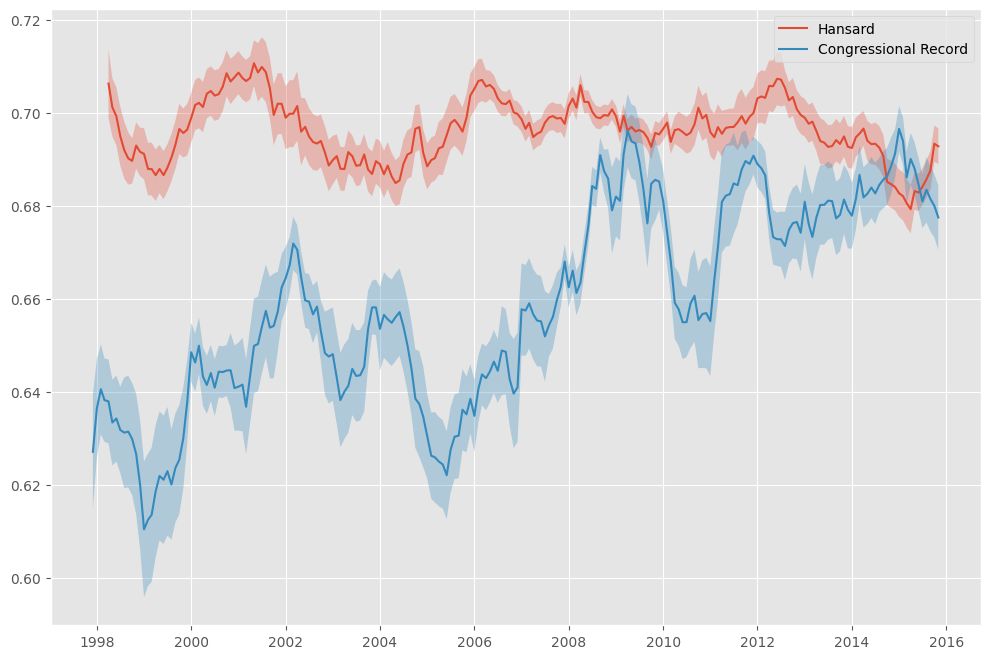

In [42]:
window = 12

plt.figure(figsize=(12, 8))
plt.plot(hansard_monthly_stats_df.index.to_timestamp(), hansard_monthly_stats_df['average_similarity'].rolling(
    window=window).mean(), label='Hansard')
plt.plot(congress_monthly_stats_df.index.to_timestamp(), congress_monthly_stats_df['average_similarity'].rolling(
    window=window).mean(), label='Congressional Record')
plt.fill_between(hansard_monthly_stats_df.index.to_timestamp(), hansard_monthly_stats_df['lower_bound'].rolling(
    window=window).mean(), hansard_monthly_stats_df['upper_bound'].rolling(window=window).mean(), alpha=0.3)
plt.fill_between(congress_monthly_stats_df.index.to_timestamp(), congress_monthly_stats_df['lower_bound'].rolling
                 (window=window).mean(), congress_monthly_stats_df['upper_bound'].rolling(window=window).mean(), alpha=0.3)

plt.legend()